In [1]:
import os
from typing import List, Tuple

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.utils import make_grid

In [6]:
import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.functional import dice
from torchmetrics.functional.classification import binary_jaccard_index

In [7]:
metadata = pd.read_csv('./data/metadata.csv')
print(metadata.shape)
metadata.head()

(704, 6)


,id,gender,age,county,ptb,remarks
0,1000,male,31,Shenxhen,0,normal
1,1001,male,64,Shenxhen,0,normal
2,1002,male,35,Shenxhen,0,normal
3,1003,male,32,Shenxhen,1,"STB,ATB,tuberculosis pleuritis"
4,1004,male,2,Shenxhen,1,secondary PTB in the bilateral upper field


In [8]:
train_metadata, test_metadata = train_test_split(metadata, random_state=42, stratify=metadata.ptb)
train_metadata, val_metadata = train_test_split(train_metadata, random_state=42, stratify=train_metadata.ptb)

len(train_metadata), len(val_metadata), len(test_metadata)

(396, 132, 176)

### Datasets and DataLoaders

In [9]:
class ImageDatasetForSegmentation(Dataset):
    def __init__(self, accessions: List[int],
                 is_train: bool = True,
                 path: str = './data') -> None:
        super().__init__()
        
        self.accessions = accessions
        self.transform = A.Compose([
            A.Resize(256, 256),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.Rotate(45, border_mode=cv2.BORDER_CONSTANT, value=0),
            ToTensorV2()
        ] if is_train else [
            A.Resize(256, 256),
            ToTensorV2()
        ])
        self.path = path

        for acc in tqdm(accessions):
            for subdir in ('images', 'masks'):
                filepath = f'{path}/{subdir}/{acc}.png'
                
                if not os.path.exists(filepath):
                    raise FileNotFoundError(filepath)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        acc = self.accessions[index]
        
        image = cv2.imread(f'{self.path}/images/{acc}.png', cv2.IMREAD_GRAYSCALE) / 255
        mask = cv2.imread(f'{self.path}/masks/{acc}.png', cv2.IMREAD_GRAYSCALE) / 255
        
        transformed = self.transform(image=image, mask=mask)
        return transformed['image'].float(), transformed['mask'].float()
        
    def __len__(self) -> int:
        return len(self.accessions)

In [10]:
train_dataset = ImageDatasetForSegmentation(train_metadata.id.to_list())
val_dataset = ImageDatasetForSegmentation(val_metadata.id.to_list(), is_train=False)
test_dataset = ImageDatasetForSegmentation(test_metadata.id.to_list(), is_train=False)

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

torch.Size([1, 256, 256]) torch.Size([256, 256])


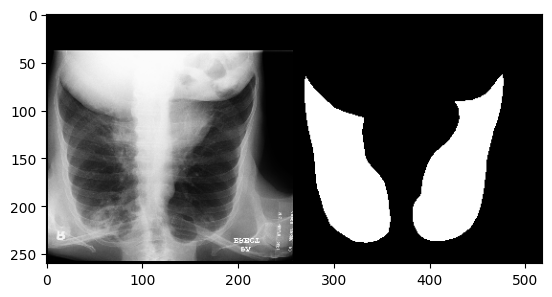

In [11]:
image, mask = train_dataset[42]
print(image.shape, mask.shape)

plt.imshow(make_grid([image, mask.unsqueeze(0)]).permute(1, 2, 0))
plt.show()

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=10)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=10)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=10)

for images, masks in train_dataloader:
    break

images.shape, masks.shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 256, 256]))

### UNet implementation

In [13]:
class UNetConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = UNetConv(in_channels, 64)
        self.conv2 = UNetConv(64, 128)
        self.conv3 = UNetConv(128, 256)
        self.conv4 = UNetConv(256, 512)
        self.conv5 = UNetConv(512, 1024)
        
        self.conv6 = UNetConv(1024, 512)
        self.conv7 = UNetConv(512, 256)
        self.conv8 = UNetConv(256, 128)
        self.conv9 = UNetConv(128, 64)

        self.deconv1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.deconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.deconv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.outconv = nn.Conv2d(64, out_channels, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv1(x)
        x2 = self.conv2(self.maxpool(x1))
        x3 = self.conv3(self.maxpool(x2))
        x4 = self.conv4(self.maxpool(x3))

        x = self.conv5(self.maxpool(x4))
        x = self.conv6(torch.cat((self.deconv1(x), x4), dim=1))
        x = self.conv7(torch.cat((self.deconv2(x), x3), dim=1))
        x = self.conv8(torch.cat((self.deconv3(x), x2), dim=1))
        x = self.conv9(torch.cat((self.deconv4(x), x1), dim=1))
        
        return self.sigmoid(self.outconv(x))


x = torch.randn(4, 1, 256, 256)
model = UNet(1, 1)
model(x).shape

torch.Size([4, 1, 256, 256])

### Lightning wrapper

In [14]:
class SegmentationModel(L.LightningModule):
    def __init__(self, model: nn.Module, lr: float = 1e-3) -> None:
        super().__init__()

        self.model = model
        self.lr = lr
        self.loss_func = nn.BCELoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x).squeeze(dim=1)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        images, true_masks = batch
        pred_masks = self(images)
        loss = self.loss_func(pred_masks, true_masks)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        images, true_masks = batch
        pred_masks = self(images)
        loss = self.loss_func(pred_masks, true_masks)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        images, true_masks = batch
        pred_masks = self(images)

        for metric_name, metric in zip(('jaccard', 'dice'), (binary_jaccard_index, dice)):
            metric_value = metric(pred_masks, true_masks.int())
            self.log(metric_name, metric_value, on_epoch=True)
    
    def predict_step(self, batch: torch.Tensor) -> torch.Tensor:
        return self(batch)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

### Training

In [15]:
model = SegmentationModel(UNet(1, 1))
trainer = L.Trainer(max_epochs=50, callbacks=[EarlyStopping(monitor='val_loss', mode='min')])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
tuner = Tuner(trainer)
tuner.lr_find(model, train_dataloaders=train_dataloader)

/home/artem/.conda/envs/python/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0005248074602497723
Restoring states from the checkpoint path at /home/artem/space/python-projects/lungs/.lr_find_184d4b03-923b-49be-8098-62952e48535e.ckpt
Restored all states from the checkpoint at /home/artem/space/python-projects/lungs/.lr_find_184d4b03-923b-49be-8098-62952e48535e.ckpt


In [17]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 31.0 M | train
1 | loss_func | BCELoss | 0      | train
----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.169   Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

### Metrics

In [18]:
trainer.test(model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           dice            │    0.9544134140014648     │
│          jaccard          │    0.9128257632255554     │
└───────────────────────────┴───────────────────────────┘

[{'jaccard': 0.9128257632255554, 'dice': 0.9544134140014648}]

### Inference

In [19]:
CHECKPOINT = './lightning_logs/version_0/checkpoints/epoch=14-step=1485.ckpt'

model = SegmentationModel.load_from_checkpoint(CHECKPOINT, model=UNet(1, 1))
model.cpu().eval()

SegmentationModel(
  (model): UNet(
    (conv1): UNetConv(
      (layers): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (conv2): UNetConv(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (conv3): U

In [24]:
for images, true_masks in test_dataloader:
    break

with torch.no_grad():
    pred_masks = model(images)

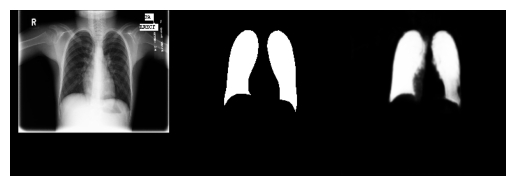

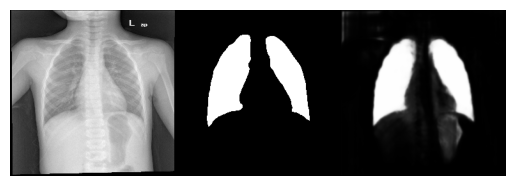

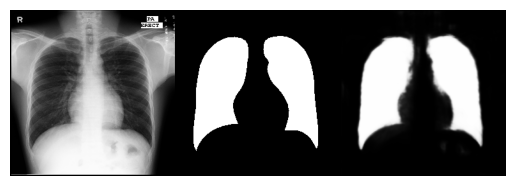

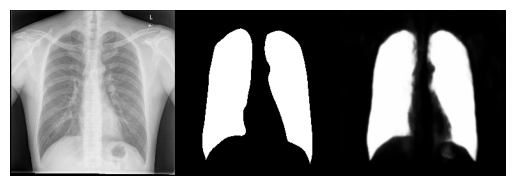

In [25]:
for image, true_mask, pred_mask, _ in zip(images, true_masks, pred_masks, range(4)):
    grid = make_grid([image, true_mask.unsqueeze(0), pred_mask.unsqueeze(0)])
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()